# Bringing evolution of conv filters to life with Matplotlib

In this notebook Im going to explore how to animate the evolution of convolutional filters throughout the training of a convolutional neural network. By analyzing the first convolutional layer we can spot if the filters are learning how to detect some low level features that can be useful for visual intelligence tasks, like classification. These low level features can be for example, edge detection and color detection. I think this is a good exploratory tool that can shed some light on the training process

For this particular notebook, I'll use pretrained models using the framework Caffe, although this could be adapted to other frameworks in the future.

## Loading pretrained weights

Lets load first a list of pretrained weights that I have in a pickle file:

In [1]:
import pickle
import pandas as pd

pickle_name = "/home/eze/Projects/tesis/experiments/results/kitti/imagenet_20.pickle"
with open(pickle_name, 'rb') as handle:
    results = pickle.load(handle)
    
results['loss'] = list(results['loss']['loss'][0::1000])

best_snap = results['best_snap']
best_snap_iter = int(results['best_snap'].split('iter_')[1].replace('.caffemodel',''))
print("Best snap", best_snap, " Best snap iteration number: ", best_snap_iter)

del results['best_snap']
del results['acc']

df = pd.DataFrame.from_records(results)
df.head()

('Best snap', '/media/eze/Datasets/snapshots/imagenet/imagenet_lmdb20_iter_52000.caffemodel', ' Best snap iteration number: ', 52000)


,loss,snaps
0,6.927309,/media/eze/Datasets/snapshots/imagenet/imagene...
1,6.230315,/media/eze/Datasets/snapshots/imagenet/imagene...
2,4.529937,/media/eze/Datasets/snapshots/imagenet/imagene...
3,0.366682,/media/eze/Datasets/snapshots/imagenet/imagene...
4,0.079643,/media/eze/Datasets/snapshots/imagenet/imagene...


## Visualize only the evolution of filters

We must generate a visualization for each snapshot:

In [2]:
import caffe

caffe.set_mode_gpu()


def set_net(deploy, caffemodel, num_channels, im_size):
    net = caffe.Net(deploy, caffemodel, caffe.TEST)  # test mode (e.g., don't perform dropout)

    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2, 0, 1))  # move image channels to outermost dimension
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    if num_channels == 3:
        transformer.set_channel_swap('data', (2, 1, 0))  # swap channels from RGB to BGR

    net.blobs['data'].reshape(1,                 # batch size
                              num_channels,      # 3-channel (BGR) images
                              im_size, im_size)  # image size is 227x227
    return (net, transformer)


def get_conv_filters(net, conv_name):
    filters = net.params[conv_name][0].data
    return filters.transpose(0, 2, 3, 1)

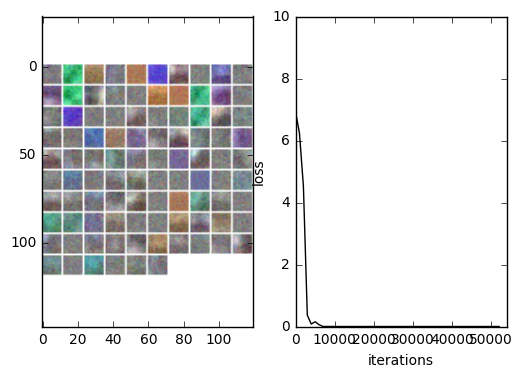

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation

shape = (96, 11, 11, 3)

deploy = "/home/eze/Projects/tesis/experiments/utils/deploys/kitti.prototxt"
imsize = 227
imchannel = 3

def preprocess_data(caffemodel, imsize, imchannel, deploy):
    net, transformer = set_net(deploy, caffemodel, imchannel, imsize)
    data = get_conv_filters(net, 'conv1')
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
                (0, 1), (0, 1))                # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return data

class SubplotAnimation(animation.TimedAnimation):
    def __init__(self, losses, caffemodels, imsize, imchannel, deploy_prototxt):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)

        xlim = len(losses)
        # caffemodels each 1000 iterations
        self.t = np.arange(0,1000*xlim, 1000)
       
        self.imsize = imsize
        self.imchannel = imchannel
        self.deploy = deploy_prototxt
        self.losses = losses
        self.caffemodels = caffemodels
        
        self.filters = np.array([preprocess_data(caffemodel, self.imsize, self.imchannel, self.deploy) for caffemodel in self.caffemodels])
        self.im = ax1.imshow(self.filters[0])
        ax1.set_aspect('equal', 'datalim')

        ax2.set_xlabel('iterations')
        ax2.set_ylabel('loss')
        self.line2 = Line2D([], [], color='black')
        ax2.add_line(self.line2)
        ax2.set_xlim(0, xlim*1000)
        ax2.set_ylim(0,10)

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        self.line2.set_data(self.t[:i], self.losses[:i])
        self.im.set_data(self.filters[i])

        self._drawn_artists = [self.im, self.line2]
        
    def new_frame_seq(self):
        return iter(range(self.t.size))

    def _init_draw(self):
        self.line2.set_data([], [])
        self.im.set_data(preprocess_data(self.caffemodels[0], self.imsize, self.imchannel, self.deploy))

ani = SubplotAnimation(results['loss'], results['snaps'], imsize, imchannel, deploy)
ani.save('filters.gif', writer='imagemagick', fps=10)
#ani.save('filters.mp4')

plt.show()